<a href="https://colab.research.google.com/github/numberjuani/crypto_cash_carry/blob/main/Cash_and_Carry_Trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install binance-connector
!pip3 install binance-futures-connector

In [ ]:
from binance.spot import Spot as SpotClient
from binance.delivery import Delivery as FuturesClient
import pandas as pd
import matplotlib.pyplot as plt
%load_ext google.colab.data_table

First we establish clients to the spot, and COIN-M margined futures.

In [232]:
spot_client = SpotClient()
futures_client = FuturesClient()

Now we obtain information for all listed contracts under the COIN-M futures, which will allows to filter by those with a valid expiration date, ignoring perpetuals.

In [233]:
coin_m_futures_info = pd.DataFrame(futures_client.exchange_info()['symbols'])
coin_m_futures_info['deliveryDate'] = pd.to_datetime(coin_m_futures_info['deliveryDate'],unit='ms')
#remove all perpetual contracts from the list
coin_m_futures_info = coin_m_futures_info[(coin_m_futures_info.contractType != 'PERPETUAL') & (coin_m_futures_info.contractStatus == 'TRADING')]
coin_m_futures_info = coin_m_futures_info[['symbol','contractType','marginAsset','deliveryDate']]

Now we obtain prices for all the futures, and filter by the contracts that do expire, which we obtained in the previous step.

In [234]:
non_perpetual_symbols = coin_m_futures_info.symbol.values

In [235]:
coin_m_futures_pricing = pd.DataFrame(futures_client.book_ticker())
non_perpetual = coin_m_futures_pricing[coin_m_futures_pricing.symbol.isin(non_perpetual_symbols)]
#since we'll be selling the futures we'll keep the bid price.
non_perpetual = non_perpetual[['symbol','bidPrice']]

Now we consolidate all the futures data into one dataframe.

In [236]:
futures = pd.merge(coin_m_futures_info,non_perpetual,on='symbol')
futures

,symbol,contractType,marginAsset,deliveryDate,bidPrice
0,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39738.2
1,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,40130.2
2,ETHUSD_220624,CURRENT_QUARTER,ETH,2022-06-24 08:00:00,2949.84
3,ETHUSD_220930,NEXT_QUARTER,ETH,2022-09-30 08:00:00,2973.08
4,ADAUSD_220624,CURRENT_QUARTER,ADA,2022-06-24 08:00:00,0.89098
5,LINKUSD_220624,CURRENT_QUARTER,LINK,2022-06-24 08:00:00,13.437
6,BCHUSD_220624,CURRENT_QUARTER,BCH,2022-06-24 08:00:00,310.87
7,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,18.114
8,XRPUSD_220624,CURRENT_QUARTER,XRP,2022-06-24 08:00:00,0.7061
9,LTCUSD_220624,CURRENT_QUARTER,LTC,2022-06-24 08:00:00,105.51


The spot endpoint has an incredibly large number of coins, so we have to narrow it down by those that have a coin-m futures that expire and those that trade with a dollar quote.

In [237]:
coins_to_consider = futures.marginAsset.values.tolist()
#as of right now these are all the stablecoins that are listed on the spot exchange
quotes_to_consider = ['USD','USDT','BUSD','USDS','USDP','DAI','USDC','TUSD']

In [238]:
spot_info = pd.DataFrame(spot_client.exchange_info()['symbols'])
spot_info = spot_info[spot_info.baseAsset.isin(coins_to_consider) & (spot_info.quoteAsset.isin(quotes_to_consider)) & (spot_info.status == 'TRADING')]
spot_info = spot_info[['symbol','baseAsset','quoteAsset']]

In [239]:
spot_prices = pd.DataFrame(spot_client.ticker_24hr())
spot_prices = spot_prices[spot_prices.symbol.isin(spot_info.symbol)]
#since the spot needs to be bought, we will save the ask price.
spot_prices = spot_prices[['symbol','askPrice']]

Now we merge spot info with its pricing data, like we did before.

In [240]:
spot_info = pd.merge(spot_prices,spot_info,on='symbol')
spot_info

,symbol,askPrice,baseAsset,quoteAsset
0,BTCUSDT,39612.69000000,BTC,USDT
1,ETHUSDT,2938.81000000,ETH,USDT
2,BNBUSDT,401.00000000,BNB,USDT
3,LTCUSDT,105.10000000,LTC,USDT
4,ADAUSDT,0.88800000,ADA,USDT
5,XRPUSDT,0.70130000,XRP,USDT
6,BTCTUSD,39649.20000000,BTC,TUSD
7,ETHTUSD,2941.48000000,ETH,TUSD
8,BNBTUSD,401.10000000,BNB,TUSD
9,XRPTUSD,0.70220000,XRP,TUSD


Now we finally are ready to merge spot and futures pairs.

In [241]:
spot_and_futures_combo = pd.merge(spot_info,futures,left_on='baseAsset',right_on='marginAsset',suffixes=('_spot', '_future'))
spot_and_futures_combo

,symbol_spot,askPrice,baseAsset,quoteAsset,symbol_future,contractType,marginAsset,deliveryDate,bidPrice
0,BTCUSDT,39612.69000000,BTC,USDT,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39738.2
1,BTCUSDT,39612.69000000,BTC,USDT,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,40130.2
2,BTCTUSD,39649.20000000,BTC,TUSD,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39738.2
3,BTCTUSD,39649.20000000,BTC,TUSD,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,40130.2
4,BTCUSDC,39629.81000000,BTC,USDC,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39738.2
...,...,...,...,...,...,...,...,...,...
69,BCHBUSD,309.90000000,BCH,BUSD,BCHUSD_220930,NEXT_QUARTER,BCH,2022-09-30 08:00:00,313.64
70,DOTBUSD,18.34000000,DOT,BUSD,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,18.114
71,DOTBUSD,18.34000000,DOT,BUSD,DOTUSD_220930,NEXT_QUARTER,DOT,2022-09-30 08:00:00,17.955
72,DOTUSDT,18.34000000,DOT,USDT,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,18.114


In [242]:
spot_and_futures_combo['bidPrice'] = spot_and_futures_combo['bidPrice'].astype(float)
spot_and_futures_combo['askPrice'] = spot_and_futures_combo['askPrice'].astype(float)
spot_and_futures_combo = spot_and_futures_combo[spot_and_futures_combo['askPrice'] != 0].copy()
spot_and_futures_combo['price_difference'] = spot_and_futures_combo['bidPrice'] - spot_and_futures_combo['askPrice']
spot_and_futures_combo['return'] = 100*(spot_and_futures_combo['price_difference']/spot_and_futures_combo['askPrice'])
spot_and_futures_combo['days_to_expiration'] = (spot_and_futures_combo.deliveryDate - pd.Timestamp.today()).dt.days
spot_and_futures_combo['annual_ror'] =  365*(spot_and_futures_combo['return']/spot_and_futures_combo['days_to_expiration'])
#for the sake of simplicity we will remove all coins with negative return for the trade, however, something worth noting might be happening with coins deep in negative terriroty, thats for you to look into
spot_and_futures_combo = spot_and_futures_combo[spot_and_futures_combo['annual_ror'] > 0]
spot_and_futures_combo.sort_values(by='annual_ror',inplace=True,ascending=False)
trades = spot_and_futures_combo[['symbol_spot','symbol_future','days_to_expiration','baseAsset','quoteAsset','bidPrice','askPrice','price_difference','return','annual_ror']].copy()
trades.rename(columns={'bidPrice':'futures bid price','askPrice':'spot asking price'},inplace=True)
trades

,symbol_spot,symbol_future,days_to_expiration,baseAsset,quoteAsset,futures bid price,spot asking price,price_difference,return,annual_ror
50,XRPUSDT,XRPUSD_220624,60,XRP,USDT,0.70610,0.7013,0.00480,0.684443,4.163696
56,XRPBUSD,XRPUSD_220624,60,XRP,BUSD,0.70610,0.7014,0.00470,0.670088,4.076371
54,XRPUSDC,XRPUSD_220624,60,XRP,USDC,0.70610,0.7015,0.00460,0.655738,3.989071
51,XRPUSDT,XRPUSD_220930,158,XRP,USDT,0.71330,0.7013,0.01200,1.711108,3.952876
41,LTCBUSD,LTCUSD_220930,158,LTC,BUSD,106.89000,105.1000,1.79000,1.703140,3.934469
37,LTCUSDT,LTCUSD_220930,158,LTC,USDT,106.89000,105.1000,1.79000,1.703140,3.934469
39,LTCUSDC,LTCUSD_220930,158,LTC,USDC,106.89000,105.1000,1.79000,1.703140,3.934469
57,XRPBUSD,XRPUSD_220930,158,XRP,BUSD,0.71330,0.7014,0.01190,1.696607,3.919376
55,XRPUSDC,XRPUSD_220930,158,XRP,USDC,0.71330,0.7015,0.01180,1.682110,3.885886
53,XRPTUSD,XRPUSD_220930,158,XRP,TUSD,0.71330,0.7022,0.01110,1.580746,3.651724


Now let's take a look at where the premiums are in general terms [The objective here is to sell the premium of collateralized asset]

In [243]:
premia = trades.groupby('baseAsset').mean()
premia.sort_values(by='annual_ror',inplace=True,ascending=False)

Text(0, 0.5, 'avg_annual_ror')

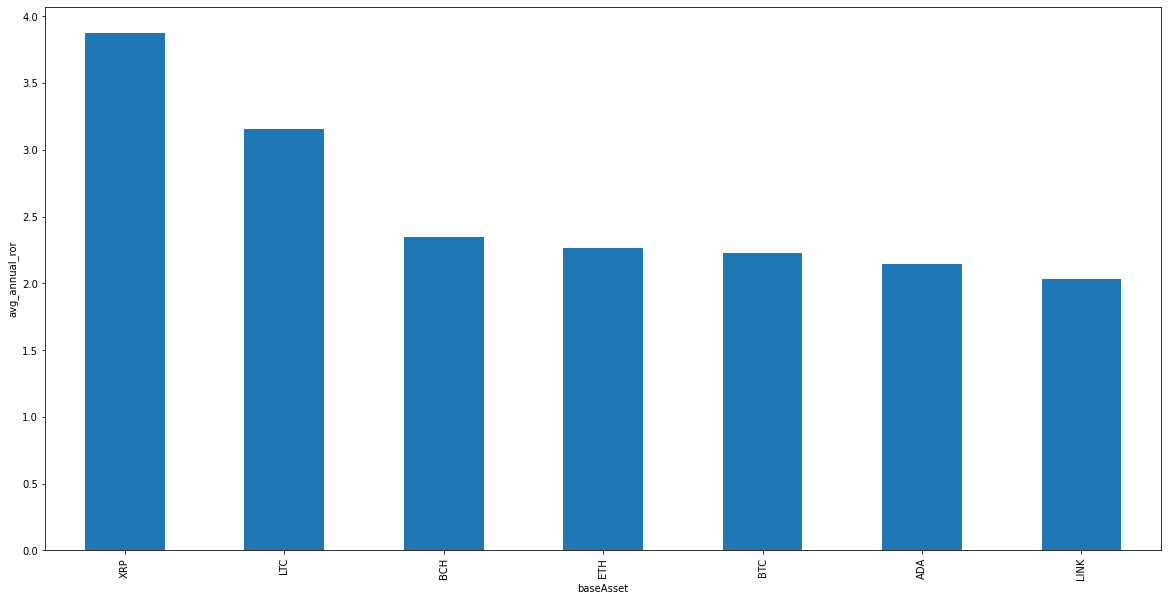

In [244]:
ax = premia.annual_ror.plot(figsize=(20,10),kind='bar')
ax.set_ylabel("avg_annual_ror")